In [1]:
import json
import pandas as pd
import string
import sys
import numpy as np
import matplotlib.pyplot as plt
import codecs
import csv
import cStringIO
%matplotlib inline

from bokeh.core.templates import JS_RESOURCES
from bokeh.embed import components
from bokeh.layouts import column
from bokeh.models import (
    ColumnDataSource, Plot, Circle, Range1d,
    LinearAxis, HoverTool, Text, HoverTool,
    SingleIntervalTicker, Slider, CustomJS)
from bokeh.palettes import Spectral7
from bokeh.plotting import figure, ColumnDataSource
from bokeh.resources import CDN

from bokeh.io import output_notebook, show
output_notebook()


Loading BokehJS ...

In [11]:
def get_team_members(teamname):
    return [name for name, teamnames in credits_by_teams if teamname in teamnames]

In [12]:
with open('movies_6feb2017.json','rb') as infile:
    movie_dicts = json.load(infile)
    
title, budget, gross, studio, rating, num_ratings, release_year = [], [], [], [], [], [], []
all_credits, directors, writers, producers, sound, artists = [], [], [], [], [], []
special_effects, visual_effects, animators, music = [], [], [], []

for movie in movie_dicts:
    
    if movie["title"] and int(movie["release_year"]) > 1979:
        title.append(movie["title"])
        release_year.append(int(movie["release_year"]))
           
        if movie["production_co"]:
            movie["production_co"] = movie["production_co"].replace('\n','')            
            studio.append(movie["production_co"].encode('utf-8'))
        else:
            studio.append("None")

        if movie["rating"] is None:
            movie["rating"] = 0            
        rating.append(float(movie["rating"]))

        if movie["num_ratings"]:
            movie["num_ratings"] = int(movie["num_ratings"].replace(',',''))
        elif movie["num_ratings"] is None:
            movie["num_ratings"]=0
        num_ratings.append(movie["num_ratings"])
            
        all_credits.append(len(movie["full_credits"]))
               
        if movie["gross"] is None:
            movie["gross"] = 0
        else:
            movie["gross"] = movie["gross"].strip()
            movie["gross"] = movie["gross"].replace(',','')
            movie["gross"] = movie["gross"].replace('$','')
        gross.append(float(movie["gross"])/1000000)
        
        credits_by_teams = movie["credits_by_teams"]
        writers.append(len(get_team_members("Writing Credits")))
        directors.append(len(get_team_members("Directed by")))
        producers.append(len(get_team_members("Produced by")))
        special_effects.append(len(get_team_members("Special Effects by")))
        visual_effects.append(len(get_team_members("Visual Effects by")))
        animators.append(len(get_team_members("Animation Department")))
        artists.append(len(get_team_members("Art Department")))

In [15]:
ratio = []
for idx, val in enumerate(animators):
    if val == 0:
        ratio.append(0)
    else:
        ratio.append(float(visual_effects[idx])/val)

In [60]:
movie_df = pd.DataFrame({'title': title, 'Studio': studio, 'Year': release_year,'num_crew': all_credits, 
                       'rating': rating, 'num_ratings': num_ratings, 'gross': gross, 'ratio': ratio,
                        'producers': producers, 'special_fx': special_effects, 'writers': writers,
                        'visual_fx': visual_effects, 'animators': animators, 'artists': artists})
crew_df = pd.pivot_table(movie_df, values='num_crew', index=['Studio'], columns=['Year'], aggfunc=np.mean)
indexed_df = movie_df.set_index(["Studio"])
sorted_df = indexed_df.sort_index()
disney_only = movie_df[movie_df.Studio == "Studio Ghibli"]
studio_list = sorted_df.index.tolist()

index_by_gross = movie_df.set_index(["gross"])
top50 = index_by_gross.sort_index(ascending = False).head(50)
top50.index.name = None

In [66]:
pixar = top50[top50.Studio == "Pixar Animation Studios"]
disney = top50[top50.Studio == "Walt Disney Pictures"]
dreamworks = top50[(top50.Studio == "DreamWorks") | (top50.Studio == "DreamWorks Animation")]
universal = top50[top50.Studio == "Universal Pictures"]
warner = top50[top50.Studio == "Warner Bros."]
twentieth = top50[(top50.Studio == "Twentieth Century Fox Animation") | 
                  (top50.Studio == "Twentieth Century Fox Film Corporation")]

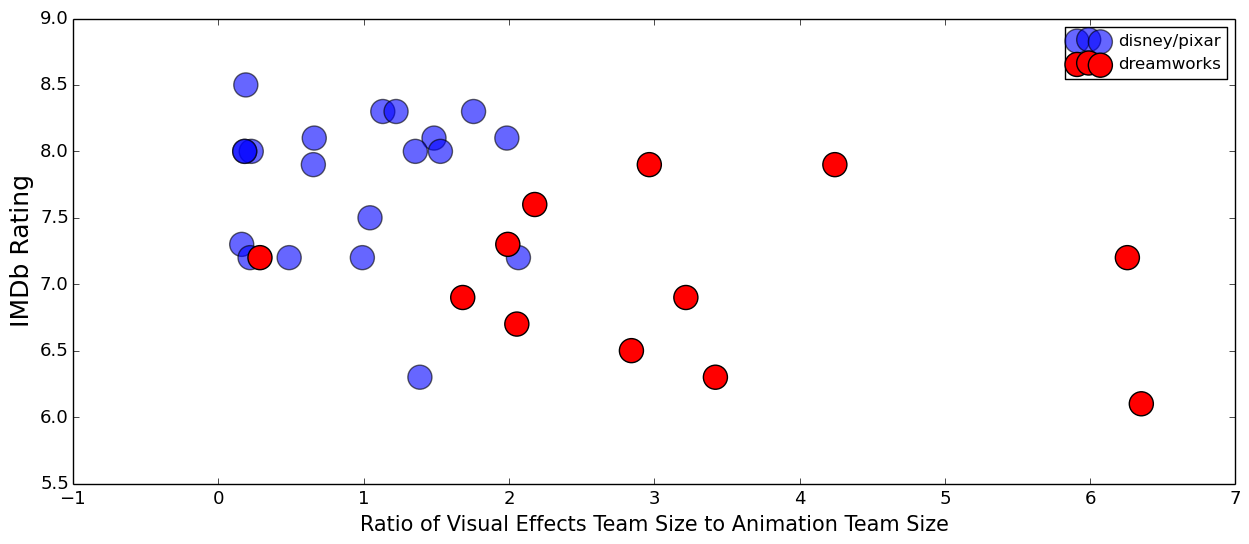

In [67]:
ax = pixar.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                               alpha = 0.6)
disney.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
                          label='disney/pixar', alpha = 0.6, ax=ax)
dreamworks.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                              color='r', label='dreamworks', ax=ax)
#universal.reset_index().plot(x="ratio", y='rating', figsize = (15,5), kind='scatter', marker='x', 
#                             s=100, label='universal', color='r', ax=ax)
#warner.reset_index().plot(x="ratio", y='rating', figsize = (15,5), kind='scatter', marker='x', 
#                          s=100, label='warner', color='r', ax=ax)
#twentieth.reset_index().plot(x="ratio", y='rating', figsize = (15,5), kind='scatter', marker='x', 
#                             s=100, label='20th century fox', color='r', ax=ax)

plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
plt.xticks(fontsize=13)
#plt.xlim([-0.5,7])
plt.yticks(fontsize=13)
plt.ylabel('IMDb Rating', fontsize=18)

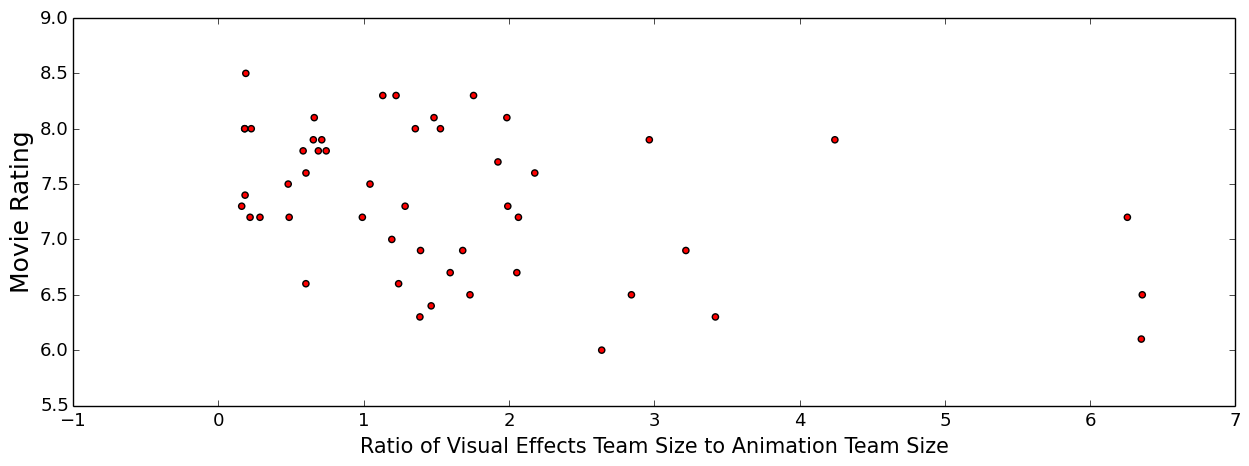

In [129]:
top50.reset_index().plot(x="ratio", y='rating', figsize = (15,5), kind='scatter', marker='o', color='r')
#movie_df.plot(x="Year", y='visual_fx', kind='scatter', marker='x', ax=ax, label = "visual_fx")
#plt.ylabel('Team Size', fontsize=14)
plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
plt.xticks(fontsize=13)
#plt.xlim([-0.5,7])
plt.yticks(fontsize=13)
plt.ylabel('Movie Rating', fontsize=18)

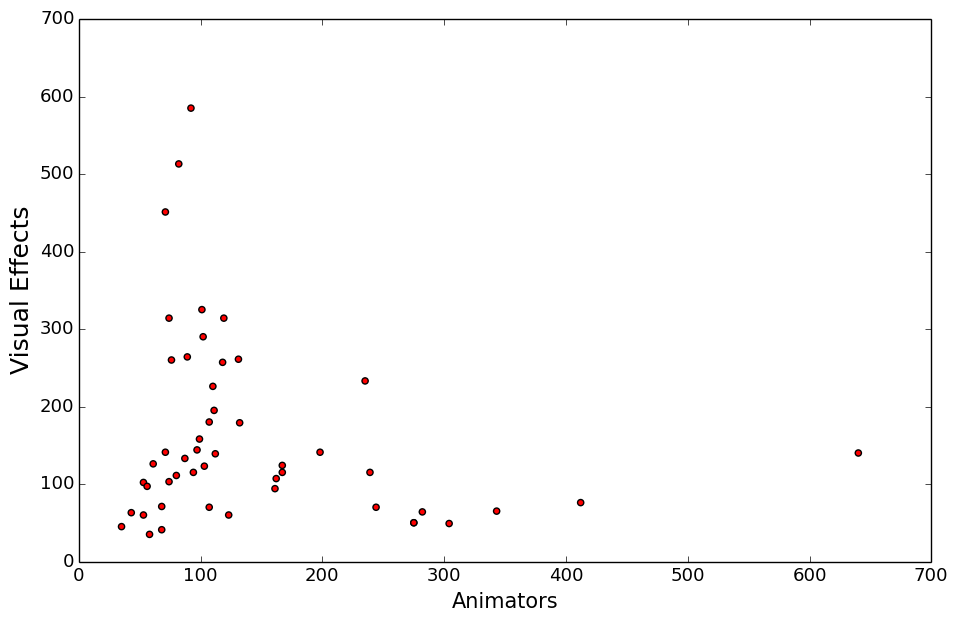

In [119]:
top50.reset_index().plot(x="animators", y='visual_fx', figsize = (11,7), kind='scatter', marker='o', color='r')
#movie_df.plot(x="Year", y='visual_fx', kind='scatter', marker='x', ax=ax, label = "visual_fx")
#plt.ylabel('Team Size', fontsize=14)
plt.xlabel('Animators',fontsize=15)
plt.xticks(fontsize=13)
#plt.xlim([-0.5,7])
plt.yticks(fontsize=13)
plt.ylabel('Visual Effects', fontsize=18)

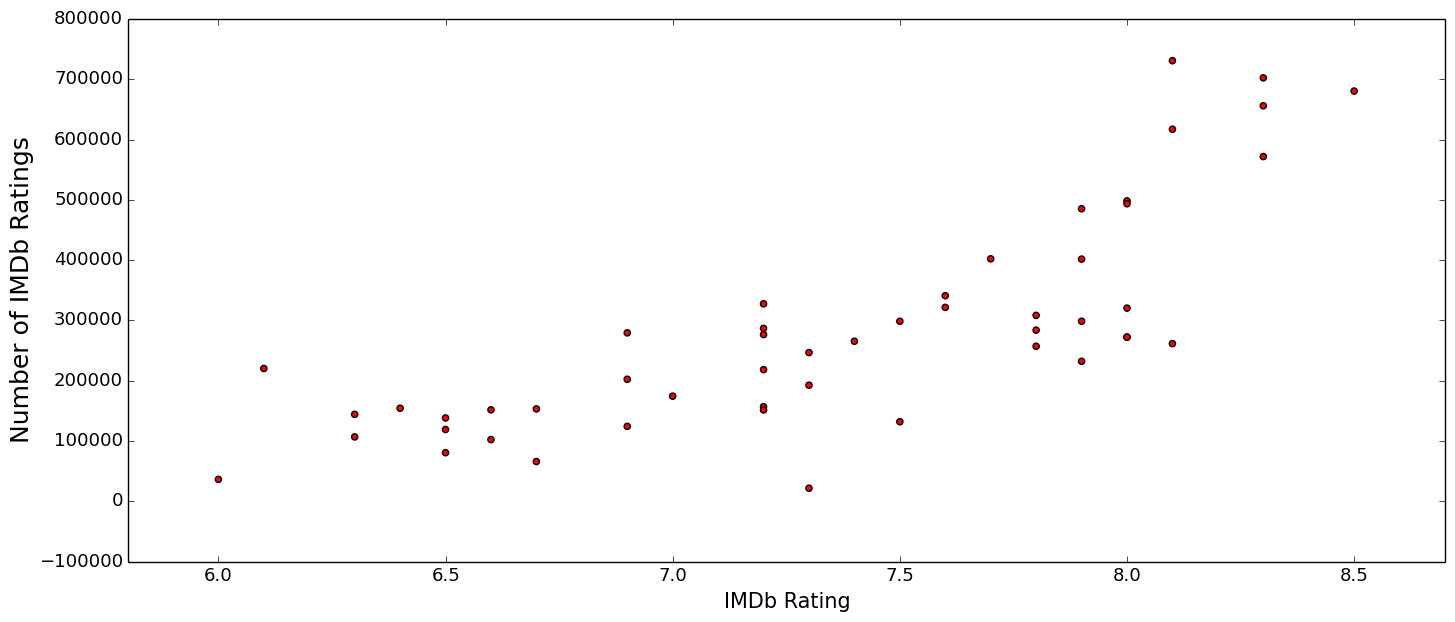

In [42]:
top50.reset_index().plot(x="rating", y='num_ratings', figsize = (17,7), kind='scatter', marker='o', color='r')
#movie_df.plot(x="Year", y='visual_fx', kind='scatter', marker='x', ax=ax, label = "visual_fx")
#plt.ylabel('Team Size', fontsize=14)
plt.xlabel('IMDb Rating',fontsize=15)
plt.xticks(fontsize=13)
plt.xlim([5.8 ,8.7])
plt.yticks(fontsize=13)
plt.ylabel('Number of IMDb Ratings', fontsize=18)

In [17]:
import plot_movies
def make_interactive_plot():
    #x-axis, y-axis, bubble_size, color, years in list form (scrolling), color in list form = _process_data()
    x_axis_df, y_axis_df, bubble_df, colors_df, labels_df, years, teams = plot_movies.process_data_teams()
    
    sources = {}

    for year in years:
        team_color = colors_df[year]
        team_color.name = 'team_color'
        
        x_variable = x_axis_df[year]
        x_variable.name = 'x_variable'
        y_variable = y_axis_df[year]
        y_variable.name = 'y_variable'
        bubble_variable = bubble_df[year]
        bubble_variable.name = 'bubble_variable'
        labels = labels_df[year]
        labels.name = 'labels'
        new_df = pd.concat([x_variable, y_variable, bubble_variable, team_color, labels], axis=1)
        sources['_' + str(year)] = ColumnDataSource(new_df)

    dictionary_of_sources = dict(zip([x for x in years], ['_%s' % x for x in years]))
    js_source_array = str(dictionary_of_sources).replace("'", "")

    xdr = Range1d(1, 10)
    ydr = Range1d(-50, 1200)
    plot = Plot(
        x_range=xdr,
        y_range=ydr,
        plot_width=800,
        plot_height=400,
        outline_line_color=None,
        toolbar_location=None,
        sizing_mode="scale_width",
    )
    AXIS_FORMATS = dict(
        minor_tick_in=None,
        minor_tick_out=None,
        major_tick_in=None,
        major_label_text_font_size="12pt",
        major_label_text_font_style="normal",
        axis_label_text_font_size="12pt",

        axis_line_color='#AAAAAA',
        major_tick_line_color='#AAAAAA',
        major_label_text_color='#666666',

        major_tick_line_cap="round",
        axis_line_cap="round",
        axis_line_width=1,
        major_tick_line_width=1,
    )

    xaxis = LinearAxis(ticker=SingleIntervalTicker(interval=1), axis_label="IMDb Rating", **AXIS_FORMATS)
    yaxis = LinearAxis(ticker=SingleIntervalTicker(interval=100), axis_label="Team Size", **AXIS_FORMATS)
    plot.add_layout(xaxis, 'below')
    plot.add_layout(yaxis, 'left')

    # ### Add the background year text
    # We add this first so it is below all the other glyphs
    text_source = ColumnDataSource({'year': ['%s' % years[0]]})
    text = Text(x=2, y=35, text='year', text_font_size='150pt', text_color='#EEEEEE')
    #plot.add_glyph(text_source, text)

    # Add the circle
    renderer_source = sources['_%s' % years[0]]
    circle_glyph = Circle(
        x='x_variable', y='y_variable', size='bubble_variable',
        fill_color='team_color', fill_alpha=0.8,
        line_color='#7c7e71', line_width=0.5, line_alpha=0.5)
    circle_renderer = plot.add_glyph(renderer_source, circle_glyph)

    # Add the hover (only against the circle and not other plot elements)
    tooltips = "@labels"
    plot.add_tools(HoverTool(tooltips=tooltips, renderers=[circle_renderer]))

    # Add the legend
    text_x = 2
    text_y = 1150
    for i, team in enumerate(teams):
        plot.add_glyph(Text(x=text_x, y=text_y, text=[team], text_font_size='10pt', text_color='#666666'))
        plot.add_glyph(Circle(x=text_x - 0.1, y=text_y + 25, fill_color=Spectral7[i], size=10, line_color=None, fill_alpha=0.8))
        text_y = text_y - 50

    # Add the slider
    code = """
        var year = slider.get('value'),
            sources = %s,
            new_source_data = sources[year].get('data');
        renderer_source.set('data', new_source_data);
        text_source.set('data', {'year': [String(year)]});
    """ % js_source_array

    callback = CustomJS(args=sources, code=code)
    slider = Slider(start=years[0], end=years[-1], value=1, step=1, title="Year", callback=callback, name='testy')
    callback.args["renderer_source"] = renderer_source
    callback.args["slider"] = slider
    callback.args["text_source"] = text_source

    # Lay it out
    return column(plot, slider)

show(make_interactive_plot())

In [68]:
import jinja2

HTML_TEMPLATE ="""
<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="utf-8">
        <title>{{ title if title else "Bokeh Plot" }}</title>
        <link href="assets/gapminder_styles.css" type="text/css" rel="stylesheet" />
    </head>
    <body>
        {{ plot_div|indent(8) }}
        {{ bokeh_js|indent(8) }}
        {{ plot_script|indent(8) }}
    </body>
</html>
"""

def write_plot_html():
    layout = make_interactive_plot()
    template = jinja2.Template(HTML_TEMPLATE)
    script, div = components(layout)
    html = template.render(
        title="Resource Allocation in Animated Movies",
        bokeh_js=JS_RESOURCES.render(js_raw=CDN.js_raw, js_files=CDN.js_files),
        plot_script=script,
        plot_div=div,
    )
    with open('interactive_plot_for_web.html', 'wb') as outfile:
        outfile.write(html)


In [69]:
write_plot_html()